<a href="https://colab.research.google.com/github/DurzaShade/musicgenrepredictor/blob/main/Audio_new_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initialising Stuff

In [ ]:
!pip install fastai --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#!pip install fastaudio

In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install path

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastaudio.ci import skip_if_ci
import timm
import path
from torch.distributions.beta import Beta

/usr/local/lib/python3.8/dist-packages/torchaudio/backend/utils.py:46: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  warnings.warn(


In [ ]:
if torch.cuda.is_available():
    print('Num GPUs:', torch.cuda.device_count())
    print('GPU Type:', torch.cuda.get_device_name(0))

Num GPUs: 1
GPU Type: Tesla T4


In [ ]:
class AudioNormalize(Transform):
    "Normalizes a single `AudioTensor`."
    def encodes(self, x:AudioTensor): return (x-x.mean()) / x.std()

In [ ]:
class StatsRecorder:
    def __init__(self, red_dims=(0,2,3)):
        """Accumulates normalization statistics across mini-batches.
        ref: http://notmatthancock.github.io/2017/03/23/simple-batch-stat-updates.html
        """
        self.red_dims = red_dims # which mini-batch dimensions to average over
        self.nobservations = 0   # running number of observations

    def update(self, data):
        """
        data: ndarray, shape (nobservations, ndimensions)
        """
        # initialize stats and dimensions on first batch
        if self.nobservations == 0:
            self.mean = data.mean(dim=self.red_dims, keepdim=True)
            self.std  = data.std (dim=self.red_dims,keepdim=True)
            self.nobservations = data.shape[0]
            self.ndimensions   = data.shape[1]
        else:
            if data.shape[1] != self.ndimensions:
                raise ValueError('Data dims do not match previous observations.')
            
            # find mean of new mini batch
            newmean = data.mean(dim=self.red_dims, keepdim=True)
            newstd  = data.std(dim=self.red_dims, keepdim=True)
            
            # update number of observations
            m = self.nobservations * 1.0
            n = data.shape[0]

            # update running statistics
            tmp = self.mean
            self.mean = m/(m+n)*tmp + n/(m+n)*newmean
            self.std  = m/(m+n)*self.std**2 + n/(m+n)*newstd**2 +\
                        m*n/(m+n)**2 * (tmp - newmean)**2
            self.std  = torch.sqrt(self.std)
                                 
            # update total number of seen samples
            self.nobservations += n

In [ ]:
class SpecNormalize(Normalize):
    "Normalize/denorm batch of `TensorImage`"
    def encodes(self, x:TensorImageBase): return (x-self.mean) / self.std
    def decodes(self, x:TensorImageBase):
        f = to_cpu if x.device.type=='cpu' else noop
        return (x*f(self.std) + f(self.mean))

In [ ]:
path = Path('/content/drive/MyDrive/Genre_Predictor/dataset')

In [ ]:
df = pd.read_csv(path/"features_30_sec.csv")
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


#Spectrogram Based classification

In [ ]:
cfg = AudioConfig.BasicMelSpectrogram(n_fft=512)
a2s = AudioToSpec.from_cfg(cfg)

/usr/local/lib/python3.8/dist-packages/torchaudio/functional/functional.py:357: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


In [ ]:
def get_x(r): 
  return path/'genres_original'/r['filename'].split('.')[0]/str(r['filename'])

In [ ]:
for index, row in df.iterrows():
    if os.path.exists(get_x(row)) == False:
      df = df.drop(index)
      print(get_x(row))

/content/drive/MyDrive/Genre_Predictor/dataset/genres_original/jazz/jazz.00054.wav


In [ ]:
auds = DataBlock(blocks = (AudioBlock, CategoryBlock),  
                 get_x = get_x, 
                 splitter = RandomSplitter(valid_pct=0.2, seed=42),
                 item_tfms = [ResizeSignal(30*1000), AudioNormalize],
                 batch_tfms = [a2s],
                 get_y = ColReader("label"))

In [ ]:
dbunch = auds.dataloaders(df, bs=32)

In [ ]:
global_stats  = StatsRecorder()
channel_stats = StatsRecorder(red_dims=(0,1,3))

# step through the training dataset
with torch.no_grad():
    for idx,(x,y) in enumerate(iter(dbunch.train)):
        # update normalization statistics
        global_stats.update(x)
        channel_stats.update(x)
    
# parse out both sets of stats
global_mean,global_std = global_stats.mean,global_stats.std
channel_mean,channel_std = channel_stats.mean,channel_stats.std

In [ ]:
GlobalSpecNorm  = SpecNormalize(global_mean,  global_std,  axes=(0,2,3))
ChannelSpecNorm = SpecNormalize(channel_mean, channel_std, axes=(0,1,3))

In [ ]:
class MixUp(Callback):
    run_after,run_valid = [Normalize],False
    def __init__(self, alpha=0.4): self.distrib = Beta(tensor(alpha), tensor(alpha))
    def before_fit(self):
        self.stack_y = getattr(self.learn.loss_func, 'y_int', False)
        if self.stack_y: self.old_lf,self.learn.loss_func = self.learn.loss_func,self.lf

    def after_fit(self):
        if self.stack_y: self.learn.loss_func = self.old_lf

    def before_batch(self):
        lam = self.distrib.sample((self.y.size(0),)).squeeze().to(self.x.device)
        lam = torch.stack([lam, 1-lam], 1)
        self.lam = lam.max(1)[0]
        shuffle = torch.randperm(self.y.size(0)).to(self.x.device)
        xb1,self.yb1 = tuple(L(self.xb).itemgot(shuffle)),tuple(L(self.yb).itemgot(shuffle))
        nx_dims = len(self.x.size())
        self.learn.xb = tuple(L(xb1,self.xb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=nx_dims-1)))
        if not self.stack_y:
            ny_dims = len(self.y.size())
            self.learn.yb = tuple(L(self.yb1,self.yb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=ny_dims-1)))

    def lf(self, pred, *yb):
        if not self.training: return self.old_lf(pred, *yb)
        with NoneReduce(self.old_lf) as lf:
            loss = torch.lerp(lf(pred,*self.yb1), lf(pred,*yb), self.lam)
        return reduce_loss(loss, getattr(self.old_lf, 'reduction', 'mean'))

In [ ]:
deltransform = Delta()
tmask = MaskTime()
cutt = SignalCutout()

In [ ]:
auds = DataBlock(blocks = (AudioBlock, CategoryBlock),  
                 get_x = get_x, 
                 splitter = RandomSplitter(valid_pct=0.2, seed=42),
                 item_tfms = [ResizeSignal(30*1000), cutt],
                 batch_tfms = [a2s],
                 get_y = ColReader("label"))
dbunch = auds.dataloaders(df, bs=32)

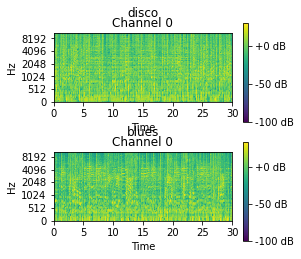

In [ ]:
dbunch.show_batch()

In [ ]:
timm.list_models('*resnet*')

['cspresnet50',
 'cspresnet50d',
 'cspresnet50w',
 'eca_resnet33ts',
 'ecaresnet26t',
 'ecaresnet50d',
 'ecaresnet50d_pruned',
 'ecaresnet50t',
 'ecaresnet101d',
 'ecaresnet101d_pruned',
 'ecaresnet200d',
 'ecaresnet269d',
 'ecaresnetlight',
 'ens_adv_inception_resnet_v2',
 'gcresnet33ts',
 'gcresnet50t',
 'gluon_resnet18_v1b',
 'gluon_resnet34_v1b',
 'gluon_resnet50_v1b',
 'gluon_resnet50_v1c',
 'gluon_resnet50_v1d',
 'gluon_resnet50_v1s',
 'gluon_resnet101_v1b',
 'gluon_resnet101_v1c',
 'gluon_resnet101_v1d',
 'gluon_resnet101_v1s',
 'gluon_resnet152_v1b',
 'gluon_resnet152_v1c',
 'gluon_resnet152_v1d',
 'gluon_resnet152_v1s',
 'inception_resnet_v2',
 'lambda_resnet26rpt_256',
 'lambda_resnet26t',
 'lambda_resnet50ts',
 'legacy_seresnet18',
 'legacy_seresnet34',
 'legacy_seresnet50',
 'legacy_seresnet101',
 'legacy_seresnet152',
 'nf_ecaresnet26',
 'nf_ecaresnet50',
 'nf_ecaresnet101',
 'nf_resnet26',
 'nf_resnet50',
 'nf_resnet101',
 'nf_seresnet26',
 'nf_seresnet50',
 'nf_seresnet1

In [ ]:
mixup  = MixUp(1.5)
learn_1 = vision_learner(dbunch, 
            vgg16_bn,
            pretrained=True,
            moms = (0.6, 0.6, 0.6),
            n_in=1,  # <- This is the only audio specific modification here
            metrics=[accuracy]).to_fp16()
learn_2 = vision_learner(dbunch, 
            alexnet,
            pretrained=True,
            moms = (0.6, 0.6, 0.6),
            n_in=1,  # <- This is the only audio specific modification here
            metrics=[accuracy]).to_fp16()
learn_3 = vision_learner(dbunch, 
            resnet50,
            pretrained=True,
            moms = (0.6, 0.6, 0.6),
            n_in=1,  # <- This is the only audio specific modification here
            metrics=[accuracy]).to_fp16()
learn_4 = vision_learner(dbunch, 
            resnet34,
            pretrained=True,
            moms = (0.6, 0.6, 0.6),
            n_in=1,  # <- This is the only audio specific modification here
            metrics=[accuracy]).to_fp16()

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

KeyboardInterrupt: ignored

In [ ]:
learn_1.fine_tune(10, 0.01)

In [ ]:
learn_1.recorder.plot_loss()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_1)
interp.plot_confusion_matrix()

In [ ]:
learn_2.fine_tune(10, 0.01)

In [ ]:
learn_2.recorder.plot_loss()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_2)
interp.plot_confusion_matrix()

In [ ]:
learn_3.fine_tune(10, 0.01)

In [ ]:
learn_3.recorder.plot_loss()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_3)
interp.plot_confusion_matrix()

In [ ]:
learn_4.fine_tune(10, 0.01)

In [ ]:
learn_4.recorder.plot_loss()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_4)
interp.plot_confusion_matrix()

In [ ]:
mixup  = MixUp()
learn_5 = vision_learner(dbunch, 
            'resnetrs50',
            pretrained=True,
            moms = (0.6, 0.6, 0.6),
            n_in=1,  # <- This is the only audio specific modification here
            metrics=[accuracy], cbs = [SaveModelCallback(), mixup]).to_fp16()

In [ ]:
learn_5.lr_find()

KeyboardInterrupt: ignored

In [ ]:
learn_5.fine_tune(30, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.761239,0.579887,0.839196,00:41


Better model found at epoch 0 with valid_loss value: 0.5798871517181396.


epoch,train_loss,valid_loss,accuracy,time
0,0.821572,0.449682,0.884422,00:40
1,0.784191,0.474552,0.874372,00:40
2,0.782061,0.466168,0.859297,00:40
3,0.771989,0.500940,0.874372,00:42
4,0.772495,0.477305,0.874372,00:41
5,0.767966,0.508233,0.854271,00:40
6,0.777239,0.486403,0.844221,00:40
7,0.799821,0.491712,0.874372,00:41
8,0.807001,0.505046,0.864322,00:43
9,0.784108,0.496781,0.864322,00:40


Better model found at epoch 0 with valid_loss value: 0.4496821463108063.
Better model found at epoch 10 with valid_loss value: 0.44041192531585693.
Better model found at epoch 11 with valid_loss value: 0.4385651648044586.
Better model found at epoch 12 with valid_loss value: 0.4233701229095459.
Better model found at epoch 19 with valid_loss value: 0.4024753272533417.
Better model found at epoch 20 with valid_loss value: 0.3958818018436432.
Better model found at epoch 21 with valid_loss value: 0.3855814039707184.
Better model found at epoch 22 with valid_loss value: 0.3728838562965393.


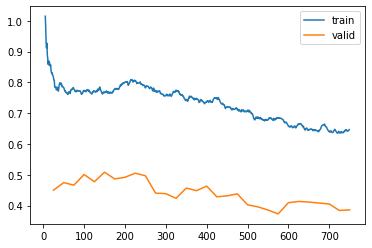

In [ ]:
learn_5.recorder.plot_loss()

In [ ]:
learn_5.save('test_r18')
# learn_2.save('test_r34')
# learn_3.save('test_xr50')

Path('models/test_r18.pth')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_5)
interp.plot_confusion_matrix()

AssertionError: ignored

In [ ]:
model_r18 = learn_5.load('/content/models/test_r18')
# model_r34 = learn_2.load('/content/models/test_r34')
# model_xr50 = learn_3.load('/content/models/test_xr50')

In [ ]:
preds, targs = model_r18.tta(n = 8)

In [ ]:
accuracy(preds, targs).item()

0.8994975090026855

In [ ]:
model_r18.export('/content/drive/Othercomputers/My Laptop (1)/Academics/ML Stuff/Genre Predictor/export_r18.pkl')